In [25]:
import pandas as pd
import numpy as np
from groq import Groq
import time 
import os
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
load_dotenv()

True

In [26]:
# import scraped data
df_restau = pd.read_csv('Restaurants.csv')
df_users = pd.read_csv('user.csv')

In [27]:
# display 5 first rows of restau data
df_restau.head()

,name,avis,link
0,Belles Beach House,"4,5 sur 5 bulles46 avis",https://www.tripadvisor.fr/Restaurant_Review-g...
1,Burosu Ramen,"5,0 sur 5 bulles2 avis",https://www.tripadvisor.fr/Restaurant_Review-g...
2,1. Maccheroni Republic,"4,5 sur 5 bulles396 avis",https://www.tripadvisor.fr/Restaurant_Review-g...
3,2. Bubba Gump Shrimp Co.,"4,5 sur 5 bulles1 629 avis",https://www.tripadvisor.fr/Restaurant_Review-g...
4,3. 71Above Restaurant and Skylounge,"4,0 sur 5 bulles262 avis",https://www.tripadvisor.fr/Restaurant_Review-g...


In [28]:
# display 5 first rows of restau data normally df_users conatins all informations needed --> no need for df_restau
df_users.head()

,restaurant_name,user_name,location,review_title,review,date,rating,user_profile_link,country
0,Belles Beach House,Zazalette,Martigues,Bon mais attention!,Nous avons commandé nos plats et le serveur no...,juil. 2024 • friends,"3,0 sur 5 bulles",https://www.tripadvisor.com/Profile/Zazalette,France
1,Belles Beach House,Momocita88,unknown,Plats savoureux,Repas très savoureux et personnel attentionné....,mars 2024 • family,"5,0 sur 5 bulles",https://www.tripadvisor.com/Profile/momocita88,not_provided
2,Belles Beach House,estelle D,unknown,« Belle » pause sur venice beach.,Déco sympa\nDj présent même en journée: playli...,sept. 2023 • couples,"5,0 sur 5 bulles",https://www.tripadvisor.com/Profile/estelleDSpt,not_provided
3,Belles Beach House,Ben,unknown,Absolument parfait !,Génial du début à la fin\nLes meilleures fries...,août 2022 • family,"5,0 sur 5 bulles",https://www.tripadvisor.com/Profile/ben_discover,not_provided
4,Belles Beach House,Erin C,Los Angeles,Grande trouvaille,J'étais ici pour le dîner et c'était une super...,févr. 2025 • solo,"5,0 sur 5 bulles",https://www.tripadvisor.com/Profile/erincZ1344NI,USA


In [29]:
df_users['location'] = df_users['location'].apply(
    lambda x: 'unknown' if isinstance(x, str) and ('contribution' in x.lower() or 'contributions' in x.lower()) else x
)

In [30]:
# display values taken by location column
print(df_users['location'].unique())

['Martigues' 'unknown' 'Los Angeles' ... 'San Ramon' 'Southern California'
 'Jyväskylä']


In [33]:
from concurrent.futures import ThreadPoolExecutor

# configurer les API Keys
API_KEYS = [
    os.getenv("TOKEN_1"),
    os.getenv("TOKEN_2"),
    os.getenv("TOKEN_3")
]

clients = [Groq(api_key=key) for key in API_KEYS]

# Fichiers
csv_file = "user.csv"
cache_file = "cache.json"

# Charger les données
df_users = pd.read_csv(csv_file)

# Charger le cache ou initialiser
if os.path.exists(cache_file):
    with open(cache_file, "r") as f:
        cache_data = json.load(f)
else:
    cache_data = {"last_index": -1, "cache": {}}

# Récupérer les valeurs du cache
last_index = cache_data["last_index"]
cache = cache_data["cache"]  # { "California": "USA", "Paris": "France", ... }

# Filtrer les lignes à traiter (seulement celles avec "unknown")
rows = df_users.iloc[last_index + 1:].copy()
rows_to_process = df_users[df_users["country"].str.strip().str.lower() == "unknown"]

# Répartir les lignes entre les 3 APIs
num_rows = len(rows_to_process)
chunk_size = (num_rows // 3) + 1  # Chaque API traite environ 1/3 des lignes
chunks = [rows_to_process.iloc[i:i + chunk_size] for i in range(0, num_rows, chunk_size)]

# Fonction pour traiter un chunk avec une API spécifique
def process_chunk(chunk, client, api_index):
    global last_index  # Mettre à jour l'index global
    for index, row in chunk.iterrows():
        location = row["location"]

        if location.strip() == "unknown":
            country = "not_provided"
            df_users.at[index, "country"] = country
            df_users.to_csv(csv_file, index=False)
            continue
                    
        # Vérifier si déjà en cache
        if location in cache:
            country = cache[location]
        else:
            # Appel à l'API Groq
            completion = client.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=[
                    {
                        'role': 'user',
                        'content': f"""Please this is an automatic system. I will give you a location name, and you return the country name.
                        Example: 'California' → 'USA'
                        If it's not a place, return 'unknown'.
                        Location: {location}
                        Just return the country name or 'unknown'."""
                    }
                ],
                temperature=1,
                max_tokens=10,
                top_p=1,
                stream=False
            )

            country = completion.choices[0].message.content.strip()
            cache[location] = country  # Ajouter au cache

        # Mettre à jour le DataFrame
        df_users.at[index, "country"] = country

        # Mettre à jour l'index traité
        last_index = index

        print(f"[API {api_index}] {index} | {location} → {country}")

        # Sauvegarder tous les 10 lignes
        if index % 10 == 0:
            df_users.to_csv(csv_file, index=False)
            with open(cache_file, "w") as f:
                json.dump({"last_index": last_index, "cache": cache}, f)

        time.sleep(4)  # Éviter la surcharge API

# Exécuter les API en parallèle
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = [executor.submit(process_chunk, chunks[i], clients[i], i + 1) for i in range(len(chunks))]

# Attendre la fin de tous les traitements
for future in futures:
    future.result()

# Sauvegarde finale
df_users.to_csv(csv_file, index=False)
with open(cache_file, "w") as f:
    json.dump({"last_index": last_index, "cache": cache}, f)

print("✅ Processing complete!")


[API 1] 30 | Europe → unknown
[API 2] 4291 | no location → unknown
[API 3] 5954 | Jupiter → unknown
[API 2] 4300 | no location → unknown[API 3] 6494 | Bear → Unknown

[API 1] 241 | no location → unknown
[API 1] 1551 | Manage → Unknown
[API 2] 5190 | no location → unknown
[API 1] 1680 | Europe → unknown
[API 2] 5291 | Jupiter → unknown
✅ Processing complete!


In [40]:
# some value assigned to country as unknown we will replace it by 'not_provided' 
df_users[df_users['country'] == 'unknown'] = 'not_provided'
print(df_users[df_users['country'] == 'unknown'])


Empty DataFrame
Columns: [restaurant_name,  user_name, location, review_title, review, date, rating, user_profile_link, country]
Index: []


C:\Users\user\AppData\Local\Temp\ipykernel_3328\778162290.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=countries, y=counts, palette="viridis")
C:\Users\user\AppData\Local\Temp\ipykernel_3328\778162290.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


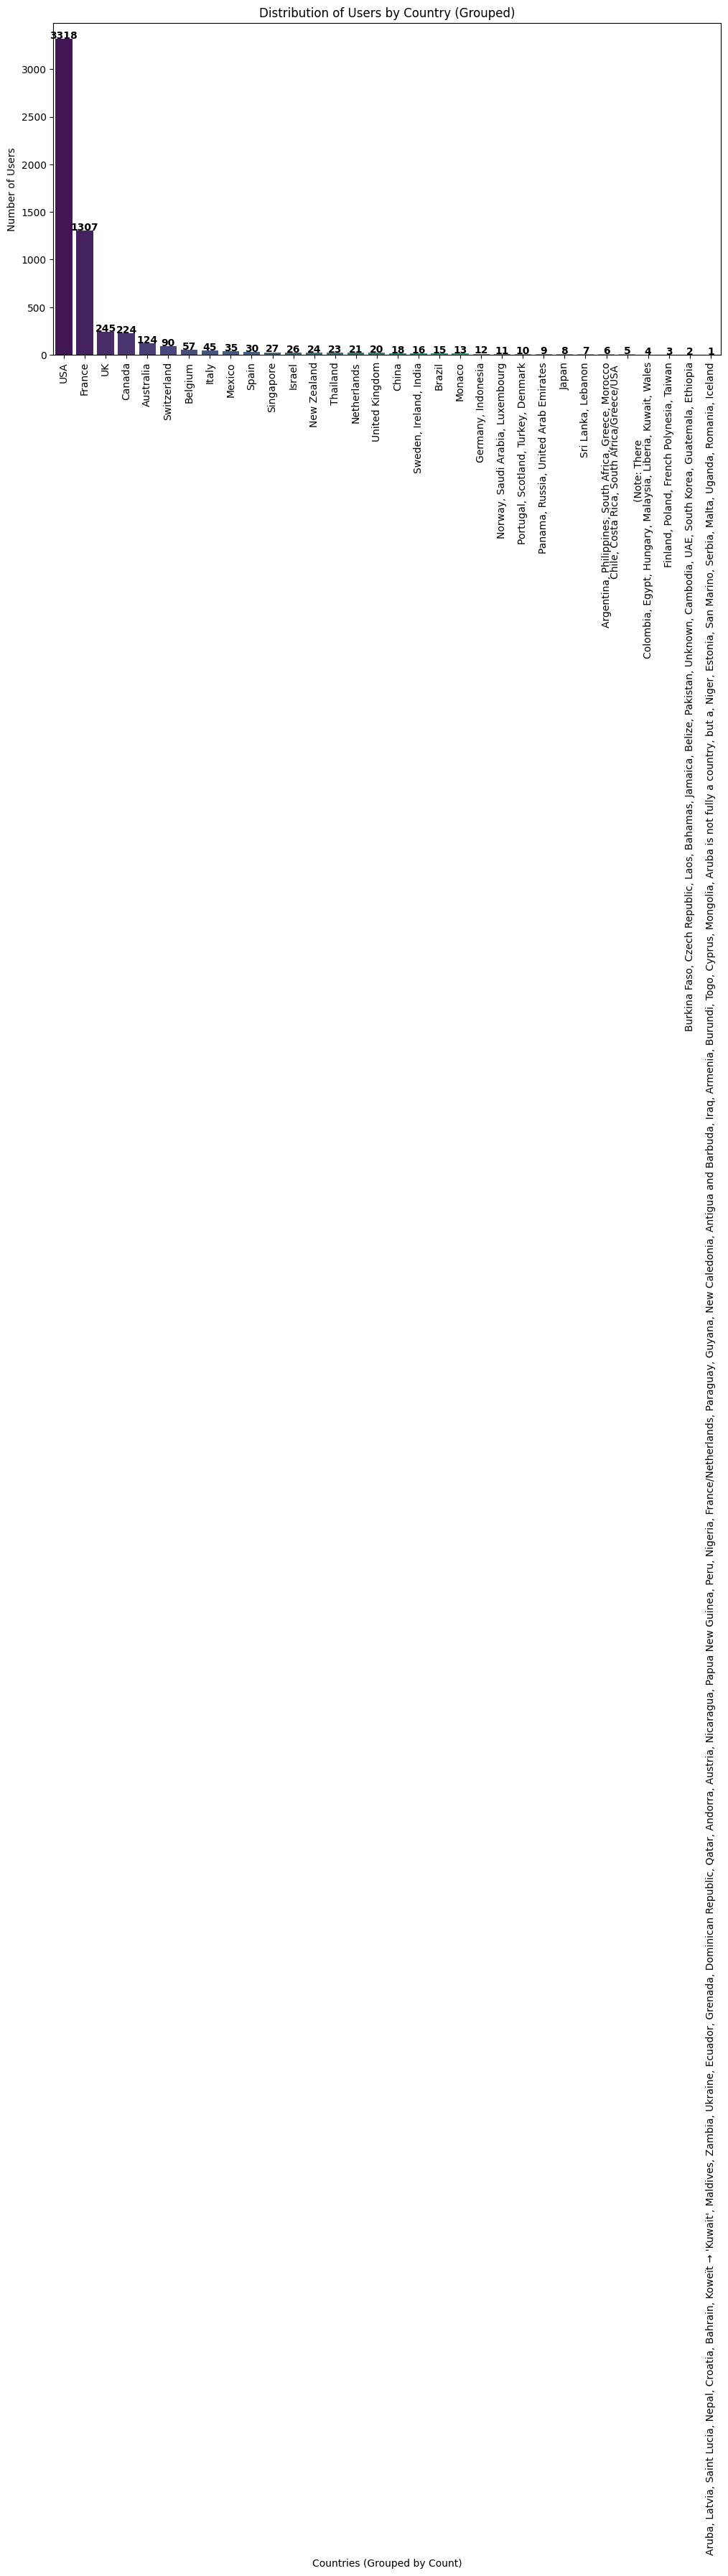

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exclure les valeurs "not_provided"
filtered_df = df_users[df_users["country"] != "not_provided"]

# Compter les occurrences de chaque pays
country_counts = filtered_df["country"].value_counts()

# Inverser la relation {pays: count} -> {count: [liste des pays]}
count_to_countries = {}
for country, count in country_counts.items():
    count_to_countries.setdefault(count, []).append(country)

# Convertir en listes pour le tracé
counts = list(count_to_countries.keys())
countries = [", ".join(count_to_countries[count]) for count in counts]

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=countries, y=counts, palette="viridis")

# Ajouter les valeurs au-dessus des barres
for i, count in enumerate(counts):
    ax.text(i, count + 2, str(count), ha='center', fontsize=10, fontweight='bold')

# Rotation des étiquettes pour éviter le chevauchement
plt.xticks(rotation=90)

# Labels et titre
plt.xlabel("Countries (Grouped by Count)")
plt.ylabel("Number of Users")
plt.title("Distribution of Users by Country (Grouped)")

# Sauvegarde et affichage
plt.tight_layout()
plt.savefig("country_histogram_grouped.png", dpi=300)
plt.show()
